In [1]:
import torch
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet, load_keypoints_from_csv

def inference_with_patches(model, image, device='cpu'):
    """
    Esegue inference su immagine 800x800 suddivisa in patch (top, bot, frame).

    Parameters
    ----------
    model : nn.Module
        Modello UNet addestrato.
    image : np.array shape (800, 800)
        Immagine di input normalizzata float32 (0-1).
    device : str
        Dispositivo ('cpu' o 'cuda').
    binary_threshold : float
        Soglia per binarizzare la heatmap di output.

    Returns
    -------
    final_heatmap : np.array shape (800, 800)
        Heatmap finale di probabilità (float 0-1).
    binary_map : np.array shape (800, 800)
        Heatmap binarizzata.
    """

    model.eval()
    model.to(device)

    h, w = image.shape
    assert h == 800 and w == 800, "Immagine deve essere 800x800"

    center_x = w // 2
    center_y = h // 2
    half = 208 // 2

    # Estrai patch come in training
    patch_top = image[center_y - 208:center_y, center_x - half:center_x + half]
    patch_bot = image[center_y:center_y + 208, center_x - half:center_x + half]

    patch_frame = image.copy()
    patch_frame[center_y - 208:center_y + 208, center_x - half:center_x + half] = 0

    to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Converti in tensor batch 1, canale 1
    input_top = to_tensor(patch_top)
    input_bot = to_tensor(patch_bot)
    input_frame = to_tensor(patch_frame)

    with torch.no_grad():
        out_top = torch.sigmoid(model(input_top)).cpu().squeeze().numpy()  # (208, 208)
        out_bot = torch.sigmoid(model(input_bot)).cpu().squeeze().numpy()  # (208, 208)
        out_frame = torch.sigmoid(model(input_frame)).cpu().squeeze().numpy()  # (800, 800)

    # Ricostruisci heatmap finale
    final_heatmap = out_frame.copy()
    final_heatmap[center_y - 208:center_y, center_x - half:center_x + half] = out_top
    final_heatmap[center_y:center_y + 208, center_x - half:center_x + half] = out_bot

    return final_heatmap


In [2]:
directory = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/4000_1000_160_180_npy'

image = np.load(f'{directory}/images/val/event_5.npy')  # (800, 800) float32 normalizzato 0-1
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load('best_unet_patch.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))

final_heatmap = inference_with_patches(model, image, device='cuda')
final_heatmap = torch.sigmoid(torch.tensor(final_heatmap)).numpy()

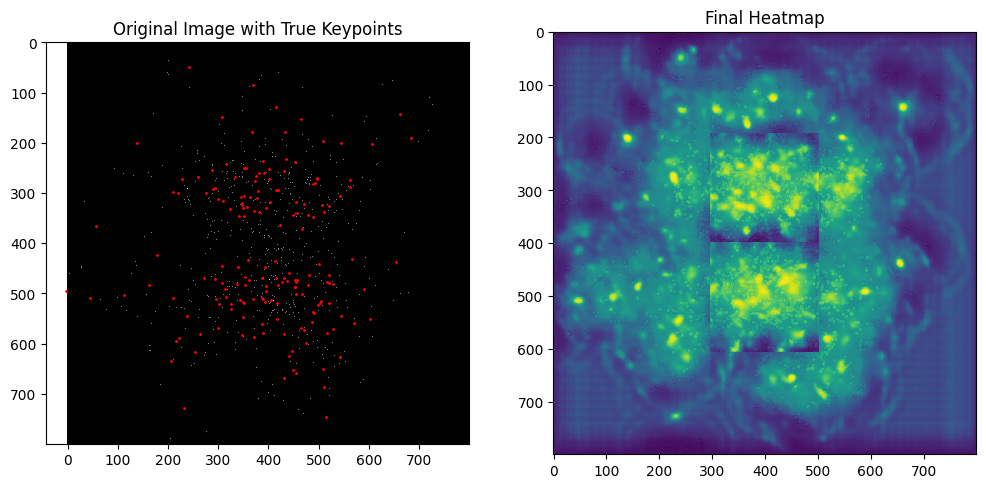

In [3]:
# printa le immagini
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.title('Final Heatmap')
plt.imshow(final_heatmap, cmap='viridis', interpolation='nearest')

plt.subplot(1, 2, 1)
plt.title('Original Image with True Keypoints')
plt.imshow(image, cmap='gray', interpolation='nearest')
keypoints = load_keypoints_from_csv(f'{directory}/centers/val/event_5_centers.csv')
for x, y in keypoints:
    plt.plot(x, y, '.', markersize=2, color='red')
plt.show()